# Attention-based Encoder Decoder Automatic Speech Recognition Model

### Author: Lakshay Sethi
#### Custom Architecture 2 (Designed by Lakshay Sethi through Ablations)
##### Ablations Link: https://wandb.ai/verydeeplearning/hw4p2-ablations?workspace=user-lsethi

LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

### Architecture Specifications
1. Multiple BiLSTM architecture to generate and encode the feature embeddings.

3. Use of attention to increase ASR performance

In [1]:
!nvidia-smi

Wed May  3 15:32:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P8     8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# # Install some required libraries
# # Feel free to add more if you want
# !pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp 

# Imports

In [3]:
from logging import warning
from torch.utils.data.distributed import Dataset

# Import Necessary Modules you require for this HW here
import torch
import numpy as np
import torchaudio
from torchnlp.nn import LockedDropout
import torch.nn as nn
from torchsummaryX import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import accuracy_score
import gc

import zipfile
import pandas as pd
import wandb

import os
import datetime

import Levenshtein
import warnings

warnings.filterwarnings('ignore')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


# Toy Dataset Download

In [4]:
# !wget -q https://cmu.box.com/shared/static/om4qpzd4tf1xo4h7230k4v1pbdyueghe --content-disposition --show-progress
# !unzip -q hw4p2_toy.zip -d ./

# Kaggle Dataset Download

In [5]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8

In [6]:
api_token = '{"username":"lakshaysethi","key":"32d86595e55bef36c1f649381dc3282f"}'

# set up kaggle.json
# TODO: Use the same Kaggle code from HW1P2, HW2P2, HW3P2
!mkdir /home/ubuntu/.kaggle

with open("/home/ubuntu/.kaggle/kaggle.json", "w+") as f:
    f.write(api_token) # Put your kaggle username & key here

!chmod 600 /home/ubuntu/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/ubuntu/.kaggle’: File exists


In [7]:
# # To download the dataset
# !kaggle datasets download -d varunjain3/11-785-s23-hw4p2-dataset

In [8]:
# # To unzip data quickly and quietly
# !unzip -q 11-785-s23-hw4p2-dataset.zip -d ./data

# Dataset and Dataloaders

We have given you 2 datasets. One is a toy dataset, and the other is the standard LibriSpeech dataset. The toy dataset is to help you get your code implemented and tested and debugged easily, to verify that your attention diagonal is produced correctly. Note however that it's task (phonetic transcription) is drawn from HW3P2, it is meant to be familiar and help you understand how to transition from phonetic transcription to alphabet transcription, with a working attention module.

Please make sure you use the right constants in your code implementation for future modules, (SOS_TOKEN vs SOS_TOKEN_TOY) when working with either dataset. We have defined the constants accordingly below. Before you come to OH or post on piazza, make sure you aren't misuing the constants for either dataset in your code. 

## LibriSpeech

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [9]:
VOCAB = ['<pad>', '<sos>', '<eos>', 
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


# Data Loading Example

Helps understand the type of data to better write the dataloader

In [10]:
example_mfcc        = np.load("/home/ubuntu/IDL HW4/data/dev-clean/mfcc/1272-128104-0000.npy", allow_pickle=True)
example_transcript  = np.load("/home/ubuntu/IDL HW4/data/dev-clean/transcripts/1272-128104-0000.npy", allow_pickle=True)

In [11]:
print("Mfcc: ", example_mfcc)
print("Mfcc Shape: ", example_mfcc.shape)
print("Corresponding Transcript: ", example_transcript)
print("Corresponding Transcript shape: ", example_transcript.shape)

Mfcc:  [[ 7.2685485e+00 -1.3026570e+01 -2.4335361e-01 ... -3.8280669e-01
   3.4793660e-13  9.2272011e+01]
 [ 6.5928483e+00 -1.4122712e+01  2.6958530e+00 ... -9.9526042e-01
   3.4348579e-13  9.2285255e+01]
 [ 5.9508667e+00 -1.4288640e+01  4.8970914e+00 ... -1.0027217e+00
   3.4425877e-13  9.3193764e+01]
 ...
 [-1.8611323e+00 -1.2769104e+01  7.7289248e-01 ... -1.6896425e+00
   3.5929812e-13  9.9999695e+01]
 [-3.7613575e+00 -9.3966494e+00  5.8461633e+00 ... -2.0057528e+00
   3.4846396e-13  9.9148987e+01]
 [-3.2888489e+00 -5.3136020e+00  1.2327156e+01 ... -9.2915463e-01
   3.4011945e-13  9.7999786e+01]]
Mfcc Shape:  (581, 27)
Corresponding Transcript:  ['<sos>' 'M' 'I' 'S' 'T' 'E' 'R' ' ' 'Q' 'U' 'I' 'L' 'T' 'E' 'R' ' ' 'I'
 'S' ' ' 'T' 'H' 'E' ' ' 'A' 'P' 'O' 'S' 'T' 'L' 'E' ' ' 'O' 'F' ' ' 'T'
 'H' 'E' ' ' 'M' 'I' 'D' 'D' 'L' 'E' ' ' 'C' 'L' 'A' 'S' 'S' 'E' 'S' ' '
 'A' 'N' 'D' ' ' 'W' 'E' ' ' 'A' 'R' 'E' ' ' 'G' 'L' 'A' 'D' ' ' 'T' 'O'
 ' ' 'W' 'E' 'L' 'C' 'O' 'M' 'E' ' ' 'H' 'I' 'S' ' 

In [12]:
# Applying Cepstral Mean Normalization my example
example_mfcc = (example_mfcc - np.mean(example_mfcc, axis = 0))/np.std(example_mfcc, axis = 0)

time_masking = torchaudio.transforms.TimeMasking(time_mask_param = 50)
time_mfcc = time_masking(torch.Tensor(example_mfcc.transpose(1, 0)).unsqueeze(0)).squeeze(0)

freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param = 10)
freq_mfcc = freq_masking(torch.Tensor(example_mfcc.transpose(1, 0)).unsqueeze(0)).squeeze(0)

(581, 27)

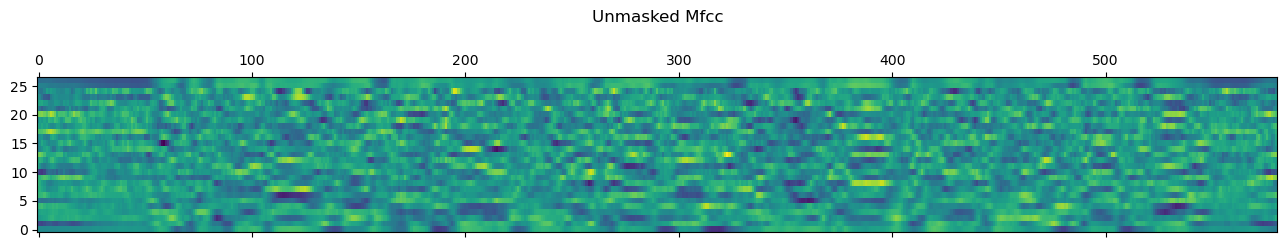

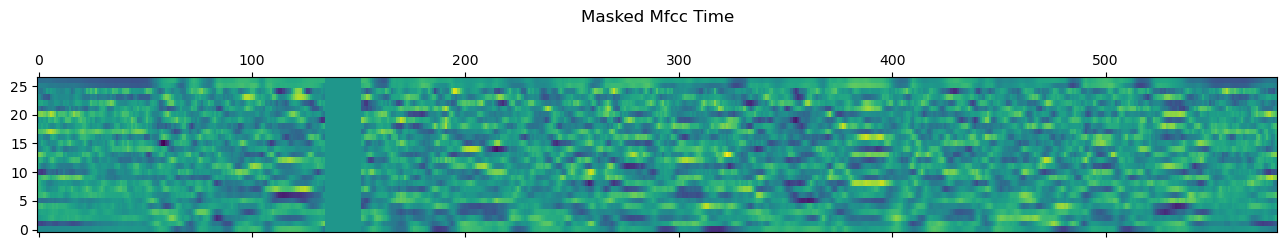

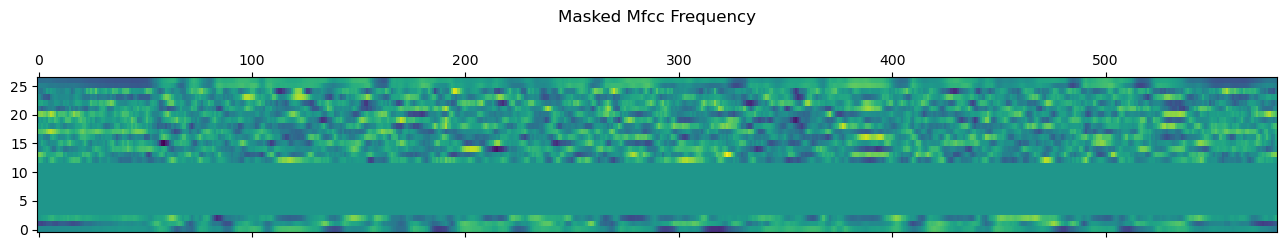

In [13]:
plt.matshow(example_mfcc.transpose(1, 0), origin='lower', aspect = 'auto')
plt.title("Unmasked Mfcc", pad = 40)
example_mfcc.shape

plt.matshow(time_mfcc, origin='lower', aspect = 'auto')
plt.title("Masked Mfcc Time", pad = 40)
example_mfcc.shape

plt.matshow(freq_mfcc, origin='lower', aspect = 'auto')
plt.title("Masked Mfcc Frequency", pad = 40)
example_mfcc.shape

# Creating Dataset

In [14]:
config_data = {
    'batch_size' : 120,
    'freq_mask'  : 8,      # Masks the MFCC Dimensions along Y-axis
    'time_mask'  : 50      # Masks the Time Dimensions along X-axis
}

In [15]:
class SpeechDataset(torch.utils.data.Dataset):
    '''
    Feel free to add arguments, additional functions, this is the 
    bare-minimum template.
    '''
    def __init__(self, root, vocab = VOCAB, vocab_map = VOCAB_MAP, partition = 'train-clean-100'):

        self.vocab = VOCAB
        self.vocab_map = VOCAB_MAP
        self.partition = partition

        # Dataloader for Testing data
        if partition == 'test-clean':
            self.dtype = "Testing"

            self.mfcc_files = []
            mfcc_dir = os.path.join(root, self.partition, 'mfcc', "")

            self.mfcc_files = os.listdir(mfcc_dir)
            self.mfcc_files.sort()

            # Length Assignment
            self.length = len(self.mfcc_files)

            self.mfccs = []
            for i in range(self.length):
                # Loading a mfcc file
                mfcc = np.load(os.path.join(mfcc_dir, self.mfcc_files[i]), allow_pickle=True)
                # Normalizing the input file/Cepstral mean normalization
                mfcc = (mfcc - np.mean(mfcc, axis = 0))/np.std(mfcc, axis = 0)

                self.mfccs.append(mfcc)

        # Dataloader for Training and Validation data
        else:
            self.dtype = "Training/Validation"
            self.mfcc_files, self.transcript_files = [], []

            mfcc_dir = os.path.join(root, self.partition, 'mfcc', "")
            transcript_dir = os.path.join(root, self.partition, 'transcripts', "")

            self.mfcc_files = os.listdir(mfcc_dir)
            self.mfcc_files.sort()

            self.transcript_files = os.listdir(transcript_dir)
            self.transcript_files.sort()
            
            # Sanity Check
            assert len(self.mfcc_files) == len(self.transcript_files)

            # Length Assignment
            self.length = len(self.mfcc_files)

            self.mfccs, self.transcripts = [], []

            for i in range(self.length):
                # Loading a mfcc file
                mfcc = np.load(os.path.join(mfcc_dir, self.mfcc_files[i]), allow_pickle=True)
                # Normalizing the input file/Cepstral mean normalization
                mfcc = (mfcc - np.mean(mfcc, axis = 0))/np.std(mfcc, axis = 0)

                # Loading the complete transcript
                transcript = np.load(os.path.join(transcript_dir, self.transcript_files[i]), allow_pickle=True)
                
                # Converting the trancript into numerical labels
                label = np.array([self.vocab_map[character] for character in transcript])

                self.mfccs.append(mfcc)
                self.transcripts.append(label)
  

    def __len__(self):
        return self.length

    
    def __getitem__(self, idx):
        # GetItem for Testing data
        if self.dtype == "Testing":
            mfcc_tensor = torch.FloatTensor(self.mfccs[idx])
            return mfcc_tensor

        # GetItem for Training/Validation data
        else:
            mfcc_tensor = torch.FloatTensor(self.mfccs[idx])
            
            ### Applying masking only if the data belongs to Training phase. Important to mask before padding
            if self.partition == 'train-clean-100':
                time_masking = torchaudio.transforms.TimeMasking(time_mask_param = config_data['time_mask'])
                freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param = config_data['freq_mask'])
            
                # Adding bathc_size dimension at 1st dimension and hanging shape as masking expects
                # the num_of sample in the 3rd dimension (2nd index) 
                mfcc_tensor = time_masking(mfcc_tensor.unsqueeze(0).permute((0, 2, 1)))
                mfcc_tensor = freq_masking(mfcc_tensor).permute((0, 2, 1)).squeeze(0)
            
            transcript_tensor = torch.tensor(self.transcripts[idx])
            
            return mfcc_tensor, transcript_tensor
        

    def collate_fn(self, batch):
        # Collate Function for Testing data
        if self.dtype == "Testing":
            batch_mfcc       = batch
            lens_mfcc        = [len(mfcc) for mfcc in batch_mfcc]
            batch_mfcc       = pad_sequence(batch_mfcc, batch_first = True, padding_value = PAD_TOKEN)

            return batch_mfcc, torch.tensor(lens_mfcc)

        # Collate Function for Training/Validation data
        else:
            batch_mfcc, batch_transcript = zip(*batch)            

            lens_mfcc        = [len(mfcc) for mfcc in batch_mfcc]
            batch_mfcc       = pad_sequence(batch_mfcc, batch_first = True, padding_value = PAD_TOKEN)

            lens_transcript  = [len(transcript) for transcript in batch_transcript]
            batch_transcript = pad_sequence(batch_transcript, batch_first = True, padding_value = PAD_TOKEN)

            return batch_mfcc, batch_transcript, torch.tensor(lens_mfcc), torch.tensor(lens_transcript)

In [16]:
gc.collect()

10027

In [17]:
train_dataset = SpeechDataset(root = "/home/ubuntu/IDL HW4/data", vocab = VOCAB, vocab_map = VOCAB_MAP, partition = 'train-clean-100')
dev_dataset   = SpeechDataset(root = "/home/ubuntu/IDL HW4/data", vocab = VOCAB, vocab_map = VOCAB_MAP, partition = 'dev-clean')
test_dataset  = SpeechDataset(root = "/home/ubuntu/IDL HW4/data", vocab = VOCAB, vocab_map = VOCAB_MAP, partition = 'test-clean')

train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    num_workers = 4,
    batch_size  = config_data['batch_size'],
    pin_memory  = True if DEVICE == 'cuda' else False,
    shuffle     = True,
    collate_fn  = train_dataset.collate_fn
)
dev_loader   = torch.utils.data.DataLoader(
    dataset     = dev_dataset,
    num_workers = 2,
    batch_size  = config_data['batch_size'],
    pin_memory  = True if DEVICE == 'cuda' else False,
    shuffle     = False,
    collate_fn  = dev_dataset.collate_fn
)
test_loader  = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    num_workers = 2,
    batch_size  = config_data['batch_size'],
    pin_memory  = True if DEVICE == 'cuda' else False,
    shuffle     = False,
    collate_fn  = test_dataset.collate_fn
)

print("\nChecking the shapes of the data...")
for batch in train_loader:
    x, y, x_len, y_len = batch
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    break

gc.collect()


Checking the shapes of the data...
torch.Size([120, 1640, 27]) torch.Size([120, 298]) torch.Size([120]) torch.Size([120])


0

torch.Size([27, 1688])


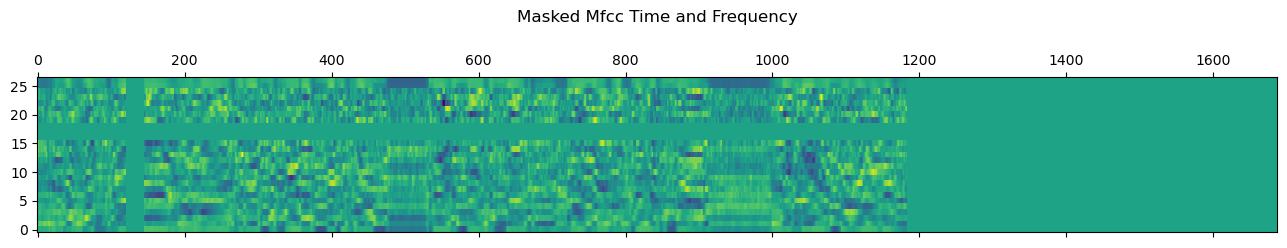

In [18]:
# Note: There is a possibility of that the below plot appears extreme masking in the end due to padding
for batch in train_loader:
    x, y, x_len, y_len = batch
    plt.matshow(x[0].transpose(0, 1), origin='lower', aspect = 'auto')
    plt.title("Masked Mfcc Time and Frequency", pad = 40)
    print(x[0].transpose(0, 1).shape)
    break

# Sanity Check on data

In [19]:
# mfcc_lens = [len(mfcc) for mfcc in train_dataset.mfccs]
# transcript_lens = [len(transcript) for transcript in train_dataset.transcripts]

# max_len_mfcc = max(mfcc_lens)
# avg_len_mfcc = np.mean(np.array(mfcc_lens))
# max_len_trans = max(transcript_lens)
# avg_len_trans = np.mean(np.array(transcript_lens))

# del mfcc_lens, transcript_lens

# print("Partition loaded:  train-clean-100")
# print("Max mfcc length:  ", max_len_mfcc)
# print("Average mfcc length:  ", avg_len_mfcc)
# print("Max trasncript length:  ", max_len_trans)
# print("Average trasncript length:  ", avg_len_trans)

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

In [20]:
# mfcc_lens = [len(mfcc) for mfcc in dev_dataset.mfccs]
# transcript_lens = [len(transcript) for transcript in dev_dataset.transcripts]

# max_len_mfcc = max(mfcc_lens)
# avg_len_mfcc = np.mean(np.array(mfcc_lens))
# max_len_trans = max(transcript_lens)
# avg_len_trans = np.mean(np.array(transcript_lens))

# del mfcc_lens, transcript_lens

# print("Partition loaded:  dev-clean")
# print("Max mfcc length:  ", max_len_mfcc)
# print("Average mfcc length:  ", avg_len_mfcc)
# print("Max trasncript length:  ", max_len_trans)
# print("Average trasncript length:  ", avg_len_trans)

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

In [21]:
# mfcc_lens = [len(mfcc) for mfcc in test_dataset.mfccs]

# max_len_mfcc = max(mfcc_lens)
# avg_len_mfcc = np.mean(np.array(mfcc_lens))

# del mfcc_lens

# print("Partition loaded:  test-clean")
# print("Max mfcc length:  ", max_len_mfcc)
# print("Average mfcc length:  ", avg_len_mfcc)

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

# THE MODEL 

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener: 
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## The Listener:

Psuedocode:
```python
class Listner:
  def init():
    feature_embedder = #Few layers of 1DConv-batchnorm-activation (Don't overdo)
    pblstm_encoder = #Cascaded pblstm layers (Take pblstm from #HW3P2), 
    #can add more sequential lstms 
    dropout = #As per your liking

  def forward(x,lx):
    embedding = feature_embedder(x) #optional
    encoding, encoding_len = pblstm_encoder(embedding/x,lx)
    #Regularization if needed
    return encoding, encoding_len
```



In [22]:
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [23]:
class pBLSTM(torch.nn.Module):

    def __init__(self, input_size, hidden_size, p):

        super(pBLSTM, self).__init__()

        self.bLSTM = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, dropout = p, num_layers = 1, 
                                   bidirectional = True, batch_first = True)

    def forward(self, x_packed): # x_packed is a PackedSequence

        # Padding the Packed Sequence
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first = True)

        # Calling self.trunc_reshape() to downsample the time steps of x and increase the feature dimensions
        x_reshaped, x_lens = self.trunc_reshape(x_padded, x_lens)

        # Packing the Padded Sequence
        x_packed = pack_padded_sequence(x_reshaped, x_lens, batch_first = True, enforce_sorted = False)

        # Passing the sequence through bLSTM
        out, hidden_states = self.bLSTM(x_packed)

        return out

    def trunc_reshape(self, x_padded, x_lens): 

        # Excluding and last x timestep if lenght is odd
        x_padded = x_padded[:, : (x_padded.shape[1] // 2) * 2]      # x_padded.shape = (Batch_size, Timestep, dim)

        # Reshaping x by downsampling the number of timesteps by a factor of 2 and upsampling the number of features/dimension by a factor of 2
        x_padded = x_padded.reshape(x_padded.shape[0], x_padded.shape[1]//2, x_padded.shape[2]*2)

        # Reducing the lengths by a factor of 2
        x_lens = x_lens//2

        return x_padded, x_lens

In [24]:
# Input consists of a sequence of 27-dimensional mel-spectral vectors derived from a spoken recording
# Read writeup for more
input_dimensions = example_mfcc.shape[1]

class Listener(torch.nn.Module):
    def __init__(self, hidden_dim, num_layers, dropout_p):

        super(Listener, self).__init__()
        self.lstm = nn.LSTM(input_size = input_dimensions, hidden_size = hidden_dim, num_layers = 1, 
                            dropout = dropout_p, bidirectional = True, batch_first = True)
        
        self.pBLSTMs = nn.Sequential(*[pBLSTM(hidden_dim*2*2, hidden_dim, dropout_p) for l in range(num_layers-1)])
                                    # Here hidden_dim is multiplied by because
                                    # The output from previous layer (simple bi-directional LSTM or pbLSTM) is double of hidden_dim, thus we multiply by 2
                                    # We multiply by another 2 because pbLSTM concatenates forward anc backward sequences togethor
  
    def forward(self, x, x_lens):

        # Packing the sequences for efficiency
        x_packed = pack_padded_sequence(x, x_lens, batch_first = True, enforce_sorted = False)

        # Passing the x_packed through an LSTM Layer
        out, _ = self.lstm(x_packed)

        # Passing the input through pBLSTM encoder layers
        out = self.pBLSTMs(out)

        encoder_out, encoding_lens = pad_packed_sequence(out, batch_first = True)

        return encoder_out, encoding_lens

In [25]:
# listener_model = Listener(conv_out_channel = 256, hidden_dim = 256, num_layers = 3, dropout_p = 0.3).to(DEVICE)
# print(listener_model)
# for batch in train_loader:
#     x, y, lx, ly = batch
#     summary(listener_model, x.float().to(DEVICE), lx)
#     break

## Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

Pseudocode:

```python
class Attention:
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def init(listener_hidden_size,
              speller_hidden_size,
              projection_size):

        VW = Linear(listener_hidden_size,projection_size)
        KW = Linear(listener_hidden_size,projection_size)
        QW = Linear(speller_hidden_size,projection_size)

    def set_key_value(encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        key = KW(encoder_outputs)
        value = VW(encoder_outputs)
      
    def compute_context(decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits, 
         finally we take a softmax to calculate attention energy which gets 
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''
        query = QW(decoder_context) #(batch_size, projection_size)

        raw_weights = #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        #What will be the shape of raw_weights?

        attention_weights = #What makes raw_weights -> attention_weights

        attention_context = #Multiply attention weights to values

        return attention_context, attention_weights 
```

In [26]:
class Attention(torch.nn.Module):
    def __init__(self, listener_hidden_size, speller_hidden_size, projection_size):

        super().__init__()

        self.VW = torch.nn.Linear(in_features = listener_hidden_size, out_features = projection_size, device = DEVICE)
        self.KW = torch.nn.Linear(in_features = listener_hidden_size, out_features = projection_size, device = DEVICE)
        self.QW = torch.nn.Linear(in_features = speller_hidden_size, out_features = projection_size, device = DEVICE)

        self.speller_hidden_size = speller_hidden_size
        self.projection_size = projection_size

    def set_key_value(self, encoder_outputs):
        self.key     = self.KW(encoder_outputs)     #key.shape   = (batch_size, timesteps, projection_size)
        self.value   = self.VW(encoder_outputs)     #value.shape = (batch_size, timesteps, projection_size)
        self.batch_size = encoder_outputs.shape[0]

    def compute_context(self, decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits, 
         finally we take a softmax to calculate attention energy which gets 
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)
        '''
        query = self.QW(decoder_context) #(batch_size, projection_size)

        raw_weights = (torch.bmm(self.key, query.unsqueeze(2)).squeeze(2))/np.sqrt(self.projection_size) #(batch_size, timesteps)

        attention_weights = nn.functional.softmax(raw_weights, dim = 1) #(batch_size, timesteps)

        attention_context = torch.bmm(attention_weights.unsqueeze(1), self.value)  #(batch_size, projection_size)

        return attention_context, attention_weights

In [27]:
# attention_model = Attention(listener_hidden_size = 128, speller_hidden_size = 256, projection_size = 256).to(DEVICE)
# print(attention_model)
# for batch in train_loader:
#     x, y, lx, ly = batch
#     summary(listener_model, x.to(DEVICE), lx)
#     break

## The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [28]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

    def __init__(self, attender:Attention, vocab_size, embedding_dim = 256, hidden_dim = 256, num_layers = 3, dropout = 0.2, max_steps = 550, mode = "Train"):
        super(). __init__()

        self.attend = attender # Attention object in speller
        self.max_timesteps = max_steps # Max timesteps

        self.embedding =  nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim, device = DEVICE)# Embedding layer to convert token to latent space
        
        self.lstm_cells =  nn.Sequential(nn.LSTMCell(input_size = embedding_dim + self.attend.projection_size, hidden_size = hidden_dim, device = DEVICE),
                                    *[nn.LSTMCell(input_size = hidden_dim, hidden_size = hidden_dim, device = DEVICE) for l in range(num_layers-1)])

        # For CDN (Feel free to change)
        self.output_to_char = nn.Linear(in_features = self.attend.projection_size + hidden_dim, out_features = embedding_dim, bias = True, device = DEVICE) # Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
        self.activation = nn.Tanh() # Check which activation is suggested
        self.char_prob = nn.Linear(in_features = embedding_dim, out_features = vocab_size, bias = True, device = DEVICE)# Linear layer to convert hidden space back to logits for token classification
        self.char_prob.weight = self.embedding.weight

        # Locked Dropout for Input
        self.LockedDropout = LockedDropout(dropout)
        self.dropout = nn.Dropout(p = dropout)

    def lstm_step(self, input_word, hidden_state):

        if hidden_state == None:
            hidden_state = [None] * len(self.lstm_cells)
            
        embedding = input_word

        for i in range(len(self.lstm_cells)):
            
            # Masking the hidden states
            if hidden_state[i] != None:
                h, c = hidden_state[i]       # Unpacking the tuple
                h    =  self.dropout(h)      # Dropping some of the hidden states
                hidden_state[i] = (h, c)     # Re-assigning the tupe
                
            hidden_state[i] = self.lstm_cells[i](embedding, hidden_state[i])
            embedding = hidden_state[i][0]

        return embedding, hidden_state

    def CDN(self, input):
        # Make the CDN here, you can add the output-to-char
        output = self.output_to_char(input)
        probability = self.char_prob(output)

        return probability

    def forward (self, y = None, mode = "Train", teacher_forcing_ratio = 1):
        
        if y is None:
            timesteps = self.max_timesteps
            teacher_forcing_ratio = 0
            batch_size = self.attend.batch_size
        else:
            batch_size, timesteps = y.shape
            char_embeddings = self.embedding(y)

            # Only applying locked dropout in Training function
            if mode == "Train":
                char_embeddings = self.LockedDropout(char_embeddings.permute((1, 0, 2))).permute((1, 0, 2))

        attn_context = torch.zeros(size = (batch_size, 1, self.attend.projection_size)).to(DEVICE) # initial context tensor for time t = 0
        output_symbol = torch.tensor([SOS_TOKEN] * batch_size).to(DEVICE) # Set it to SOS for time t = 0 or for the case when y == None
        raw_outputs = []  
        attention_plot = []

        hidden_states_list = [None] * len(self.lstm_cells) # Initialize your hidden_states list here similar to HW4P1

        for t in range(timesteps):
            p = np.random.random(1)# generate a probability p between 0 and 1

            # Case when teacher forcing ratio is not applied
            if p < teacher_forcing_ratio and t > 0:
                char_embed = char_embeddings[:, t-1] # Take from char_embed, else draw from probability distribution
            # Case when teacher forcing is applied 
            else:
                char_embed = self.embedding(output_symbol)

            # Concatenate the character embedding and context from attention, as shown in the diagram
            lstm_input = torch.cat([char_embed, attn_context[:, -1]], dim = 1) 

            out, hidden_state = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
            
            # What should we retrieve from forward_step to prepare for the next timestep?
            attn_context, attn_weights = self.attend.compute_context(out) # Feed the resulting hidden state into attention
           
            cdn_input = torch.cat([attn_context.squeeze(), out], dim = 1) # TODO: You need to concatenate the context from the attention module with the LSTM output hidden state, as shown in the diagram

            raw_pred = self.CDN(cdn_input) # call CDN with cdn_input

            # Generate a prediction for this timestep and collect it in output_symbols
            output_symbol = torch.argmax(nn.functional.softmax(raw_pred), dim = 1)# Draw correctly from raw_pred

            raw_outputs.append(raw_pred) # for loss calculation
            attention_plot.append(attn_weights) # for plotting attention plot

        attention_plot = torch.stack(attention_plot, dim = 1)
        raw_outputs = torch.stack(raw_outputs, dim = 1)

        return raw_outputs, attention_plot

## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [29]:
class LAS(torch.nn.Module):
    def __init__(self, hidden_dim_listener = 256, num_layers_listener = 3, dropout_p = 0.3,
               speller_hidden_size = 256, projection_size = 256,
               vocab_size = 31, embedding_dim = 256, num_layers_speller = 3, dropout_speller = 0.2, max_steps = 550):
        super().__init__()

        # Pass the right parameters here
        self.listener = Listener(hidden_dim = hidden_dim_listener,
                                 num_layers = num_layers_listener, 
                                 dropout_p  = dropout_p)
            

        self.attend = Attention(listener_hidden_size = 2 * hidden_dim_listener, 
                                speller_hidden_size  = speller_hidden_size, 
                                projection_size      = projection_size)

        self.speller = Speller(self.attend, 
                               vocab_size    = vocab_size,
                               embedding_dim = embedding_dim, 
                               hidden_dim    = speller_hidden_size,
                               num_layers    = num_layers_speller, 
                               dropout       = dropout_speller, 
                               max_steps     = max_steps)

    def forward(self, x, lx, y = None, mode = "Train", teacher_forcing_ratio = 1):
        # Encode speech features
        encoder_outputs, _ = self.listener(x, lx)

        # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
        # Set keys and values using the encoder outputs
        self.attend.set_key_value(encoder_outputs)

        # Decode text with the speller using context from the attention
        raw_outputs, attention_plots = self.speller(y = y, mode = mode, teacher_forcing_ratio = teacher_forcing_ratio)

        return raw_outputs, attention_plots

# Model Setup 

In [30]:
config_model = {
    'lr'                    : 1e-3,
    'epochs'                : 100,

    'hidden_dim_listener'   : 512,
    'num_layers_listener'   : 3,
    'dropout_listener'      : 0.25,

    'speller_hidden_size'   : 1024,
    'projection_size'       : 1024,

    'vocab_size'            : len(VOCAB),
    'embedding_dim_speller' : 768,
    'num_layers_speller'    : 3,
    'dropout_speller'       : 0.2,
    'max_steps'             : 550,
    
    'eta_min'               : 1e-4
}

config = {**config_data, **config_model}

In [31]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Attention Projection Size of 128
# Feel Free to Experiment with this 

torch.cuda.empty_cache()
gc.collect()

model = LAS(
    # Parameters for the Listener/Encoder
    hidden_dim_listener = config['hidden_dim_listener'], 
    num_layers_listener = config['num_layers_listener'], 
    dropout_p = config['dropout_listener'],

    # Dimensions for the Attention
    # Note that we are not passing listener_hidden_size since it is is 2*hidden_dim_listener
    speller_hidden_size = config['speller_hidden_size'], 
    projection_size = config['projection_size'],
    # Parameters for the Speller
    vocab_size = config['vocab_size'], 
    embedding_dim = config['embedding_dim_speller'],
    num_layers_speller = config['num_layers_speller'],
    dropout_speller = config['dropout_speller'], 
    max_steps = config['max_steps'])


model = model.to(DEVICE)
print(model)

for batch in train_loader:
    x, y, lx, ly = batch
    print()
    summary(model, x.float().to(DEVICE), lx, y.to(DEVICE))
    break

LAS(
  (listener): Listener(
    (lstm): LSTM(27, 512, batch_first=True, dropout=0.25, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (bLSTM): LSTM(2048, 512, batch_first=True, dropout=0.25, bidirectional=True)
      )
      (1): pBLSTM(
        (bLSTM): LSTM(2048, 512, batch_first=True, dropout=0.25, bidirectional=True)
      )
    )
  )
  (attend): Attention(
    (VW): Linear(in_features=1024, out_features=1024, bias=True)
    (KW): Linear(in_features=1024, out_features=1024, bias=True)
    (QW): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (speller): Speller(
    (attend): Attention(
      (VW): Linear(in_features=1024, out_features=1024, bias=True)
      (KW): Linear(in_features=1024, out_features=1024, bias=True)
      (QW): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (embedding): Embedding(31, 768)
    (lstm_cells): Sequential(
      (0): LSTMCell(1792, 1024)
      (1): LSTMCell(1024, 1024)
      (2): LSTMCell(1024, 

In [32]:
!nvidia-smi

Wed May  3 15:33:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P0    30W /  70W |   9547MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
torch.cuda.empty_cache()

# Loss Function, Optimizers, Scheduler

In [34]:
optimizer   = torch.optim.AdamW(model.parameters(), lr = config['lr']) # Feel free to experiment if needed

criterion   = torch.nn.CrossEntropyLoss(reduction = 'mean', ignore_index = PAD_TOKEN) #check how would you fill these values : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

scaler      = torch.cuda.amp.GradScaler()

scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = config['epochs'], 
                                                         eta_min = config['eta_min'], verbose = True)

Adjusting learning rate of group 0 to 1.0000e-03.


# Levenshtein Distance

In [35]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens

**Note: Very Important to uncomment and comment the right distance basis if toy dataset is used or not**


In [36]:
# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        #################################################################
        #################################################################
        #################################################################
        #################################################################
        ################### Remember This ###############################

        # Distance for main dataset
        dist        += Levenshtein.distance(pred_string, y_string)

        # Distance for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

        #################################################################
        #################################################################
        #################################################################
        #################################################################

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Validation functions 


In [37]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.float().to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y = y, mode = "Train", teacher_forcing_ratio = teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with 
            # your implementation
            loss        =  criterion(raw_predictions.reshape(-1, len(VOCAB)), y.reshape(-1) )

            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.06f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.07f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.04f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [38]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.float().to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None, mode = "Eval")

        # Greedy Decoding
        greedy_predictions   = torch.argmax(raw_predictions, dim = -1) # TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.06f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

# Experiment

In [39]:
# Login to Wandb
import wandb
wandb.login(key="2a3537b39181a31bafb5eabede64d932c94e54e8")

# Save your model architecture in a txt file, and save the file to Wandb
# run = wandb.init(
#     name = "RNN_HW4_NewArch", ## Wandb creates random run names if you skip this field
#     reinit = True, ### Allows reinitalizing runs when you re-run this cell
#     # run_id = ### Insert specific run id here if you want to resume a previous run
#     # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
#     project = "hw4p2-ablations", ### Project should be created in your wandb account 
#     config = config ### Wandb Config for your run
# )

# Use below syntax for resuming a run
run = wandb.init(
    name = "RNN_HW4_NewArch",
    id = "iahoac3n",
    resume = "allow",
    project = "hw4p2-ablations",
    config = config
)


wandb: Currently logged in as: lsethi (verydeeplearning). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


In [40]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1], 
         'epoch'                    : epoch}, 
         path
    )

def load_model(path, model, metric= 'valid_acc', optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return (model, optimizer, scheduler, epoch, metric)

In [41]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

In [42]:
model, optimizer, scheduler, epoch, metric = load_model("/home/ubuntu/IDL HW4/Epoch_checkpoint_Main_NewArch.pth",
                                                        model, 'Validation_dist', optimizer, scheduler)

In [44]:
scheduler.step()

Adjusting learning rate of group 0 to 9.4434e-04.


In [45]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0009443380060197382
    maximize: False
    weight_decay: 0.01
)

In [47]:
last_epoch_completed = epoch
start = last_epoch_completed + 1
end = config["epochs"]
best_lev_dist = 25.59225 # if you're restarting from some checkpoint, use what you saw there.
epoch_model_path = 'Epoch_checkpoint_Main_NewArch.pth'
best_model_path = 'Best_checkpoint_Main_NewArch.pth'


Epoch: 18/100


Training Loss:  0.12249847041333423
Training Perplexity:  1.1303521975749682
Levenshtein Distance:  23.566321601104203


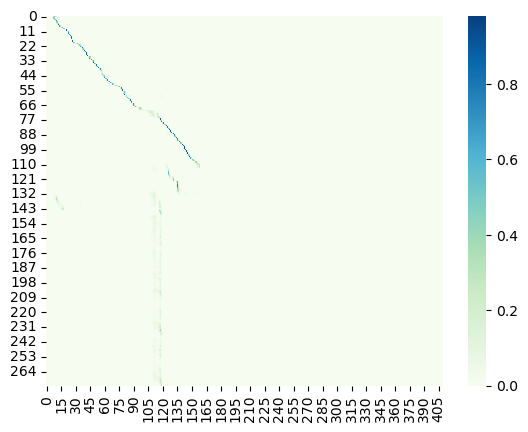

Saved epoch model
Adjusting learning rate of group 0 to 9.3733e-04.
Saved best model

Epoch: 19/100


Training Loss:  0.11000371470796962
Training Perplexity:  1.1163088098293592
Levenshtein Distance:  25.4228088336784


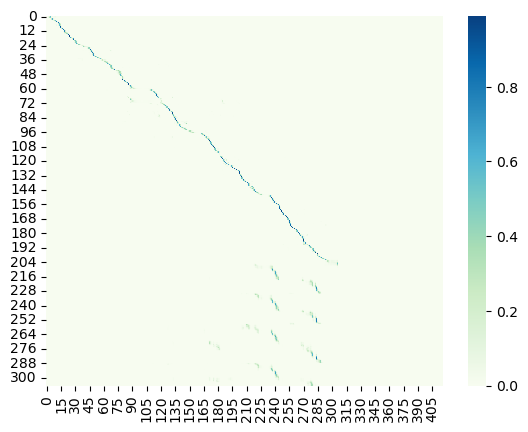

Saved epoch model
Adjusting learning rate of group 0 to 9.2995e-04.

Epoch: 20/100


Train:  47%|█████▏     | 112/238 [11:41<13:15,  6.32s/it, loss=0.098306, lr=0.0009299, perplexity=1.1033, tf_rate=1.0000]

In [ ]:
teacher_forcing_rate = 1

torch.cuda.empty_cache()
gc.collect()

for epoch in range(start, config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    # Call train and validate, get attention weights from training
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, teacher_forcing_rate)
    running_lev_dist = validate(model, dev_loader)

    # Print your metrics
    print("Training Loss: ", running_loss)
    print("Training Perplexity: ", running_perplexity)
    print("Levenshtein Distance: ", running_lev_dist)

    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb
    wandb.log({
        'Train_Loss'        : running_loss,  
        'Train_Perplexity'  : running_perplexity, 
        'Validation_dist'   : running_lev_dist, 
        'learning_rate'     : curr_lr,
        'tf_rate'           : teacher_forcing_rate
    })

    save_model(model, optimizer, scheduler, ['Validation_dist', running_lev_dist], epoch, epoch_model_path)
    wandb.save(epoch_model_path)
    print("Saved epoch model")

    # Optional: Scheduler Step / Teacher Force Schedule Step
    # Remember to keep this empty for CosineAnnealingLR scheduler
    scheduler.step()

    if (epoch+1)%20 == 0:
        teacher_forcing_rate = teacher_forcing_rate  - 0.1

    if running_lev_dist <= best_lev_dist:
        best_lev_dist = running_lev_dist
        save_model(model, optimizer, scheduler, ['valid_dist', running_lev_dist], epoch, best_model_path)
        wandb.save(best_model_path)
        print("Saved best model")
        
    torch.cuda.empty_cache()
    gc.collect()

# Testing

In [ ]:
results = []

def test(model, dataloader):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Test")

    for i, (x, lx) in enumerate(dataloader):

        x, lx = x.float().to(DEVICE), lx

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None, mode = "Eval")

        # Greedy Decoding
        greedy_predictions   = torch.argmax(raw_predictions, dim = -1)

        for sentence in greedy_predictions:
            pred_sliced = indices_to_chars(sentence, VOCAB)
            pred_string = ''.join(pred_sliced)
        
            results.append(pred_string)

        batch_bar.update()

        del x, lx, greedy_predictions, pred_sliced, pred_string
        torch.cuda.empty_cache() 

    batch_bar.close()

In [ ]:
test(model, test_loader)

data_dir = "./IDL_HW4/submissions.csv"
df = pd.DataFrame({"label": results})
df = df.reset_index()
df.to_csv(data_dir, index = False)

In [ ]:
! kaggle competitions submit -c attention-based-speech-recognition-slack -f "./IDL_HW4/submissions.csv" -m "I made it!!! wohooo"